In [1]:
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath('.')))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader

from model.yolov3 import Maskv3
from data.transform import get_yolo_transform
from data.dataset import YOLOMaskDataset, COCO_CLASSES
from data.collate import maskv3_collate_fn

from utils.convert import cells_to_boxes, xywh2tlbr
from utils.cleanup import nms_by_class
from utils.display import draw_boxes, draw_mask, get_color_mask, get_color

%load_ext autoreload
%autoreload 2

## Hyperparameter

In [3]:
# DATASET RELATED
IMG_SIZE = 416
N_CLASSES = 80

# MODEL RELATED
SCALES = [ 13, 26, 52 ]
ANCHORS = [
    [[0.28, 0.22], [0.38, 0.48], [0.9, 0.78]],
    [[0.07, 0.15], [0.15, 0.11], [0.14, 0.29]],
    [[0.02, 0.03], [0.04, 0.07], [0.08, 0.06]],
]

## Load Dataset

In [4]:
reverse = T.ToPILImage()
transform = get_yolo_transform(IMG_SIZE, mode='test')

In [5]:
dataset = YOLOMaskDataset(csv_file="../download/COCO/test.csv",
                         img_dir="../download/COCO/images/",
                         mask_dir="../download/COCO/masks/",
                         anchors=ANCHORS,
                         scales=SCALES,
                         n_classes=N_CLASSES,
                         transform=transform)

In [6]:
print("Number of samples:", len(dataset))

Number of samples: 4953


## Load Pretrained Model

In [7]:
DEVICE = "cuda:1"

IN_CHANNELS = 3
NUM_CLASSES = 80
NUM_MASKS = 32
NUM_FEATURES = 128

In [8]:
checkpoint = torch.load('../run/maskv3_coco_overfit/best.pth', map_location={ "cuda:0": DEVICE })

In [9]:
model = Maskv3(in_channels=IN_CHANNELS,
               num_classes=NUM_CLASSES,
               num_masks=NUM_MASKS,
               num_features=NUM_FEATURES)

In [10]:
model = model.to(DEVICE)
model.load_state_dict(checkpoint['model'])
model = model.eval()

In [11]:
torch_anchors = torch.tensor(ANCHORS)
torch_scales = torch.tensor(SCALES)
SCALED_ANCHORS = (
    torch_anchors * (
        torch_scales
        .unsqueeze(1)
        .unsqueeze(1)
        .repeat(1, 3, 2)
    )
)
SCALED_ANCHORS = SCALED_ANCHORS.to(DEVICE)

## Model Inference

In [12]:
dataloader = DataLoader(dataset,
                        batch_size=1,
                        collate_fn=maskv3_collate_fn)

In [13]:
imgs, masks, targets = next(iter(dataloader))

imgs = imgs.to(DEVICE)

In [14]:
outs, prototypes = model(imgs)

## Extract bounding boxes

In [15]:
CONF_THREHSOLD = 0.7

pred_boxes = []

for idx, out in enumerate(outs):
    scale = out.size(2)
    anchors = SCALED_ANCHORS[idx]
    anchors = anchors.reshape(1, 3, 1, 1, 2)
    # Convert prediction to correct format
    out[..., 0:2] = torch.sigmoid(out[..., 0:2])
    out[..., 2:4] = torch.exp(out[..., 2:4])*anchors
    out[..., 4:5] = torch.sigmoid(out[..., 4:5])
    # Class label
    probs = F.softmax(out[..., 5:5+NUM_CLASSES], dim=-1)
    _, indices = torch.max(probs, dim=-1)
    indices = indices.unsqueeze(-1)
    # Mask Coefficients
    out[..., 5+NUM_CLASSES:] = torch.tanh(out[..., 5+NUM_CLASSES:])
    # Convert to prediction
    pred = torch.cat([
            out[..., :5],
            indices,
            out[..., 5+NUM_CLASSES:]
            ], dim=-1)
    # Convert cooridnate system (xywh in normalized format)
    pboxes = cells_to_boxes(cells=pred, scale=scale)
    # Extrat cell with confidence
    obj_mask = pboxes[..., 4] > CONF_THREHSOLD
    boxes = pboxes[obj_mask]
    pred_boxes.extend(boxes.tolist())
    
pred_boxes = torch.tensor(pred_boxes)

In [16]:
# Perform NMS
IOU_THRESHOLD = 0.4

nms_boxes = []
for c in range(NUM_CLASSES):
    nms_pred_boxes = nms_by_class(target=c,
                                 bboxes=pred_boxes,
                                 iou_threshold=IOU_THRESHOLD)
    nms_boxes.extend(nms_pred_boxes)
    
nms_boxes = np.array(nms_boxes)

In [17]:
nms_boxes.shape

(5, 38)

## Combine Prototypes with bounding boxes

In [18]:
bboxes, masks = [], []

for bbox in nms_boxes:
    box = bbox[:6]
    coefs = bbox[6:]
    coefs = torch.FloatTensor(coefs)
    coefs = coefs.to(DEVICE)
    mask = torch.einsum('c,chw->hw', [coefs, prototypes[0]])
    mask = torch.sigmoid(mask)
    mask = mask.detach().cpu().numpy()
    bboxes.append(box)
    masks.append(mask)

## Show Prototypes

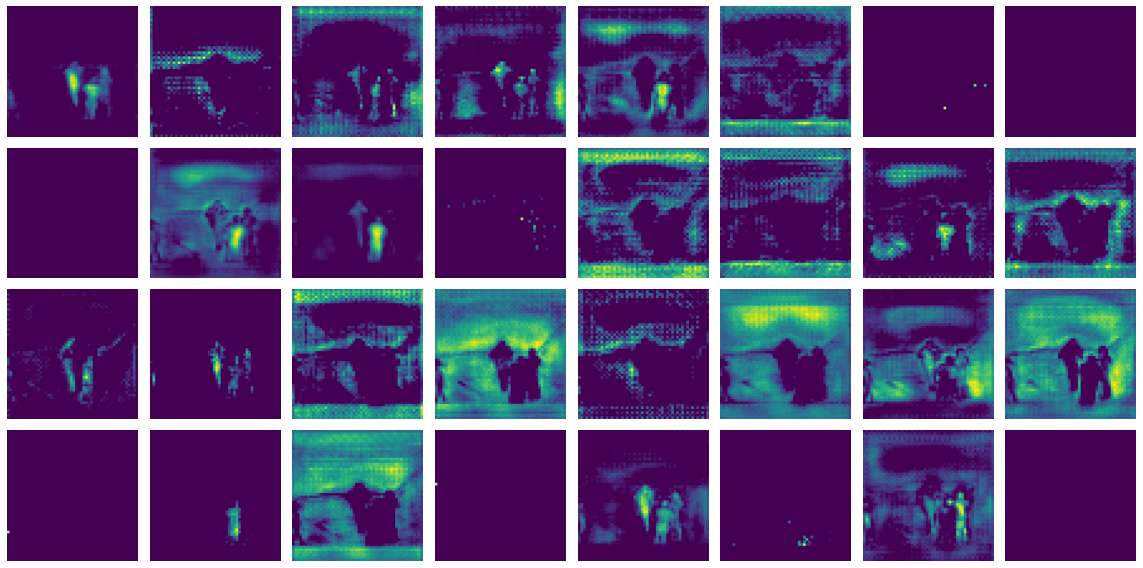

In [19]:
nrows = 4
ncols = len(prototypes[0]) // nrows

proto_masks = prototypes[0].detach().cpu().numpy()

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 8))
for i in range(nrows):
    for j in range(ncols):
        idx = i*ncols+j
        proto_mask = proto_masks[idx]
        axes[i][j].imshow(proto_mask)
        axes[i][j].set_axis_off()
plt.tight_layout()

## Show Combined Prototypes

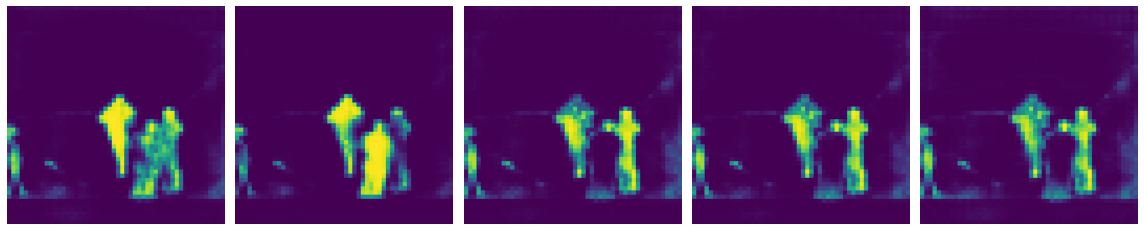

In [20]:
ncols = len(masks)

fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(16, 8))

if ncols == 1:
    axes.imshow(masks[0])
    axes.set_axis_off()
else:
    for idx, (bbox, mask) in enumerate(zip(bboxes, masks)):
        mask = np.array((mask*255), dtype=np.uint8)
        axes[idx].imshow(mask)
        axes[idx].set_axis_off()

plt.tight_layout()

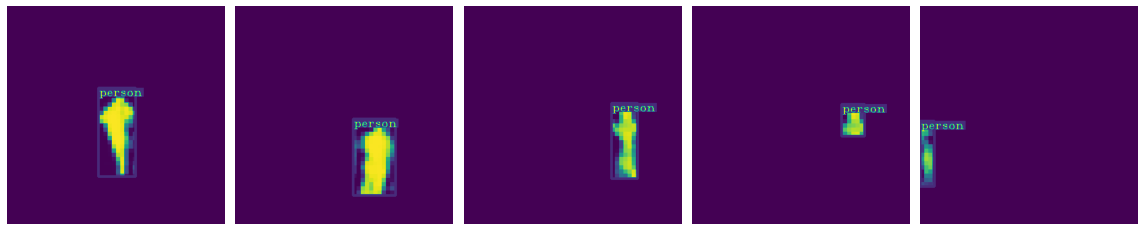

In [21]:
ncols = len(masks)

fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(16, 8))

if ncols == 1:
    axes.imshow(masks[0])
    axes.set_axis_off()
else:
    for idx, (bbox, mask) in enumerate(zip(bboxes, masks)):
        mask = np.array((mask*255), dtype=np.uint8)
        
        img_width = mask.shape[1]
        img_height = mask.shape[0]
        bbox[0] *= img_width
        bbox[1] *= img_height
        bbox[2] *= img_width
        bbox[3] *= img_height
        
        canvas = np.zeros_like(mask, dtype=np.uint8)
        instance = mask[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        canvas[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])] = instance
        draw_boxes(canvas, bbox.reshape(1, -1), COCO_CLASSES)
        
        axes[idx].imshow(canvas)
        axes[idx].set_axis_off()

plt.tight_layout()

## Show Overlapped Mask with Raw Image

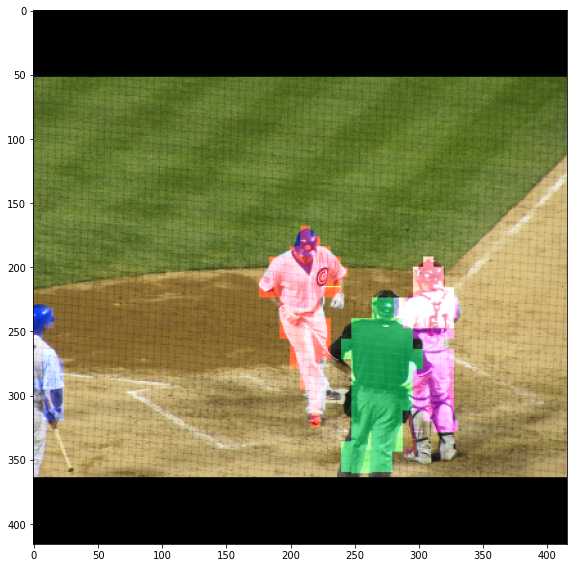

In [22]:
img = reverse(imgs[0].detach().cpu())
img = np.array(img)

for idx, (bbox, mask) in enumerate(zip(bboxes, masks)):
    instance_mask = mask[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
    instance_mask = np.array(instance_mask*255, dtype=np.uint8)
    color = get_color(idx)
    instance_mask = get_color_mask(instance_mask, color)
    draw_mask(img, bbox, instance_mask)
    
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.tight_layout()